### Content Analysis Political - Abortion
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("political/Topics_FB_Political_Posts_per_partyabortion.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(453, 35)

In [5]:

posts.shape

(453, 35)

In [6]:
posts['URL']

0      https://www.facebook.com/latinosvstrump/posts/...
1      https://www.facebook.com/Latinos4Biden/posts/1...
2      https://www.facebook.com/LatinosforJoe/posts/5...
3      https://www.facebook.com/Latinos4Biden/posts/1...
4      https://www.facebook.com/LatinosforJoe/posts/6...
                             ...                        
448    https://www.facebook.com/groups/16256741844186...
449    https://www.facebook.com/groups/16256741844186...
450    https://www.facebook.com/groups/16256741844186...
451    https://www.facebook.com/groups/16256741844186...
452    https://www.facebook.com/groups/16256741844186...
Name: URL, Length: 453, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-08-28 06:57:35 EDT
1    2020-10-08 21:24:17 EDT
2    2020-08-25 17:06:41 EDT
3    2020-10-19 09:28:26 EDT
4    2020-10-26 17:59:46 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-08-28 06:57:35-04:00
1     2020-10-08 21:24:17-04:00
2     2020-08-25 17:06:41-04:00
3     2020-10-19 09:28:26-04:00
4     2020-10-26 17:59:46-04:00
                 ...           
448   2020-10-11 14:48:25-04:00
449   2020-10-06 16:23:43-04:00
450   2020-09-27 19:10:28-04:00
451   2020-09-24 23:38:29-04:00
452   2020-08-28 13:59:54-04:00
Name: converted_date, Length: 453, dtype: datetime64[ns, tzlocal()]

In [11]:
posts['converted_date']=posts['converted_date'].dt.date

In [12]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,4
1,2020-08-19,2
2,2020-08-20,5
3,2020-08-21,2
4,2020-08-22,18
5,2020-08-23,6
6,2020-08-24,6
7,2020-08-25,6
8,2020-08-26,9
9,2020-08-27,7


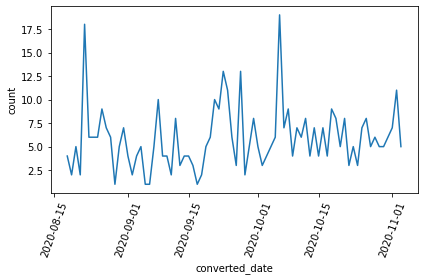

In [13]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [14]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
169,4476,DONALD TRUMP PARA HISPANOS,NaN,442514499638810,5246.0,2020-10-25 22:41:54 EDT,Link,10,5,6,...,Estados Unidos y 31 países firman declaración ...,"Este jueves, Estados Unidos fue el anfitrión d...",NaN,NaN,22,-1.68,“Declararemos inequívocamente que no existe el...,“Declararemos inequívocamente que no existe el...,Republican,2020-10-25


In [15]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [16]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [17]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [18]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
DONALD TRUMP PARA HISPANOS,77
Latinos For Trump -California Group,33
Republican National Hispanic Assembly - Official Group,32
Colombianos Y Latinoamericanos que apoyamos a Donald Trump,31
Arizona Latino Republican Association,24
Latinos For Trump.,20
Mexicans for Donald Trump,19
CARA - Cuban American Republican Alliance,16
Republican National Hispanic Assembly,16


## Tokenize words and Clean-up text

In [19]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0      Si esto te da asco, mucho asco, entonces es qu...
1      There you go! #hypocrites https://www.google.c...
2      If true, this is a very serious charge. https:...
3      Interesting analysis regarding Roe v Wade as a...
4      Presidential elections have consequences. http...
6       Prominent evangelical leaders have just relea...
7       It harms Christians' credibility when they pr...
8      “El historial de Kamala Harris es perfectament...
9      Not all souls matter During his acceptance spe...
10     President Donald Trump’s administration contin...
11     Unapologetically pro life Just days away from ...
12     President Donald J. Trump the protector of chi...
13     No queremos a "Que-mala" Kamala Harris, candid...
14     “President Trump and Vice President Mike Pence...
15     Amy Coney Barrett – Our Next Conservative Supr...
16     The most pro life President cuts off even more...
17      BREAKING NEWS: President Trump announces he w...
18     #cristianos #Trump #Evan

In [20]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(369,)

In [21]:
# Convert to list
data = content.cleanMessage.tolist()

In [22]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['si', 'esto', 'te', 'da', 'asco', 'mucho', 'asco', 'entonces', 'es', 'que', 'estas', 'comenzando', 'entender', 'la', 'mentalidad', 'republicana', 'los', 'valores', 'familiares', 'de', 'la', 'activista', 'contra', 'el', 'aborto', 'fueron', 'expuestos', 'como', 'mentiras', 'para', 'que', 'toda', 'la', 'nacion', 'las', 'viera', 'comentarios', 'cruelmente', 'racistas', 'sobre', 'su', 'propio', 'hijo', 'adoptivo', 'linda', 'oradora', 'de', 'la', 'convencion', 'republicana'], ['there', 'you', 'go', 'hypocrites']]


#### Creating Bigram and Trigram Models

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['si', 'esto', 'te', 'da', 'asco', 'mucho', 'asco', 'entonces', 'es', 'que', 'estas', 'comenzando', 'entender', 'la', 'mentalidad', 'republicana', 'los', 'valores', 'familiares', 'de', 'la', 'activista', 'contra', 'el', 'aborto', 'fueron', 'expuestos', 'como', 'mentiras', 'para', 'que', 'toda', 'la', 'nacion', 'las', 'viera', 'comentarios', 'cruelmente', 'racistas', 'sobre', 'su', 'propio', 'hijo', 'adoptivo', 'linda', 'oradora', 'de', 'la', 'convencion', 'republicana']


## Remove Stopwords, Make Bigrams and Lemmatize

In [25]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [28]:
data_lemmatized[0]

['dar',
 'asco',
 'asco',
 'entonces',
 'entender',
 'mentalidad',
 'republicano',
 'valorar',
 'familiar',
 'activista',
 'abortar',
 'exponer',
 'mentira',
 'comentario',
 'cruelmente',
 'racista',
 'hijo',
 'adoptivo',
 'republicano']

In [29]:
print(data_words_nostops[1:2])

[['go', 'hypocrites']]


## Bag of Words

In [30]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [31]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [32]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [33]:
final_dict.most_common(1000)

[('trump', 334),
 ('president / presidente', 164),
 ('decir', 139),
 ('abortar', 92),
 ('hacer', 91),
 ('vida', 86),
 ('ano', 71),
 ('ley', 64),
 ('mujer', 62),
 ('apoyar', 59),
 ('america', 58),
 ('poder', 56),
 ('votar', 55),
 ('hombre', 55),
 ('democratas', 51),
 ('solo', 48),
 ('nuevo', 48),
 ('derecho', 48),
 ('usar', 46),
 ('partir', 44),
 ('personar', 44),
 ('unir', 42),
 ('hoy', 41),
 ('tambien', 41),
 ('candidato', 40),
 ('juez', 39),
 ('bien', 39),
 ('defender', 39),
 ('bueno', 38),
 ('poblar', 38),
 ('creer', 37),
 ('claro', 36),
 ('crear', 35),
 ('pasar', 34),
 ('familia', 34),
 ('dejar', 34),
 ('querer', 33),
 ('medio', 32),
 ('casar', 32),
 ('ahora', 32),
 ('hijo', 31),
 ('ninos', 31),
 ('mundo', 31),
 ('ver', 31),
 ('social', 29),
 ('dar', 28),
 ('valorar', 28),
 ('ser', 28),
 ('poner', 28),
 ('control', 27),
 ('historia', 27),
 ('grande', 27),
 ('tiempo', 27),
 ('paz', 26),
 ('mal', 26),
 ('estadounidense', 25),
 ('vivir', 25),
 ('mundial', 25),
 ('menos', 25),
 ('milló

In [34]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [35]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [36]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [37]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,2.045969
abortar,2.786369
decir,2.802629
presidente,2.924519
hacer,2.981677
vida,3.042302
ano,3.275917
america,3.302585
apoyar,3.302585
solo,3.387142


In [38]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [39]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
asco,0.523966
republicano,0.343700
adoptivo,0.261983
cruelmente,0.261983
mentalidad,0.261983
comentario,0.215713
mentira,0.203596
activista,0.198636
familiar,0.194198
entonces,0.190184


In [40]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(evento)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


unique_messages  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Repeated messages

In [41]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [42]:
##results.sort_values(by='Counts',ascending=False)

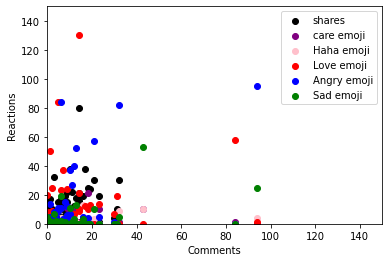

In [43]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [44]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1)]]


[[('abortar', 1),
  ('activista', 1),
  ('adoptivo', 1),
  ('asco', 2),
  ('comentario', 1),
  ('cruelmente', 1),
  ('dar', 1),
  ('entender', 1),
  ('entonces', 1),
  ('exponer', 1),
  ('familiar', 1),
  ('hijo', 1),
  ('mentalidad', 1),
  ('mentira', 1),
  ('racista', 1),
  ('republicano', 2),
  ('valorar', 1)]]

## Buiding the Topic Model

In [45]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [46]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.050*"vida" + 0.023*"crear" + 0.021*"defender" + 0.019*"ver" + 0.019*"hoy" '
  '+ 0.018*"mundo" + 0.018*"dar" + 0.018*"poder" + 0.017*"derecho" + '
  '0.014*"elección"'),
 (1,
  '0.018*"senator" + 0.003*"meyer" + 0.003*"nanómetro" + 0.000*"produced" + '
  '0.000*"everyone" + 0.000*"next" + 0.000*"local" + 0.000*"largest" + '
  '0.000*"physical" + 0.000*"getting"'),
 (2,
  '0.046*"disagree" + 0.037*"candidate" + 0.034*"social" + 0.021*"topic" + '
  '0.016*"cardinal" + 0.014*"issue" + 0.009*"really" + 0.006*"hit" + '
  '0.005*"immoral" + 0.003*"except"'),
 (3,
  '0.050*"also" + 0.041*"continuo" + 0.036*"rechazar" + 0.035*"proclamar" + '
  '0.029*"executive_order" + 0.013*"georgia" + 0.011*"true" + 0.011*"side" + '
  '0.010*"fundamental" + 0.009*"rbg"'),
 (4,
  '0.065*"justice" + 0.053*"votar" + 0.052*"political" + 0.032*"advocacy" + '
  '0.027*"course" + 0.027*"race" + 0.018*"judicial" + 0.013*"medio" + '
  '0.012*"two" + 0.011*"presidential"'),
 (5,
  '0.042*"signed" + 0.033*"r

## Compute Model Perplexity and Coherence Score

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.489065707540878

Coherence Score:  0.4460607484073969


## Visualize the topics-keywords

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.390553 -0.072343       1        1  46.876904
0     -0.226942  0.311647       2        1  21.824312
9     -0.262248 -0.183003       3        1  13.361385
17    -0.048439  0.018581       4        1   5.536677
15     0.058219 -0.014981       5        1   2.021634
16     0.030555  0.004412       6        1   1.645588
4      0.062937 -0.014635       7        1   1.571267
18     0.067530 -0.007223       8        1   1.055998
3      0.068828 -0.005842       9        1   0.917299
7      0.050038 -0.009933      10        1   0.849313
5      0.068819 -0.006268      11        1   0.721649
10     0.065790 -0.005322      12        1   0.694656
2      0.061678  0.008357      13        1   0.648884
6      0.059132 -0.008075      14        1   0.559171
11     0.060786  0.004643      15        1   0.500501
14     0.060115 -0.004990      16        1   0.481041
12     0.060435 -0.004823      17        1   0.405315
13     0.052001 -0.003524      18        1   0.129442
1      0.051717 -0.003488      19        1   0.124034
19     0.049601 -0.003191      20        1   0.074920, topic_info=                      Term        Freq       Total Category  logprob  loglift
70                   trump  519.000000  519.000000  Default  30.0000  30.0000
102                  votar   91.000000   91.000000  Default  29.0000  29.0000
159                   vida  153.000000  153.000000  Default  28.0000  28.0000
19                 america   78.000000   78.000000  Default  27.0000  27.0000
115                  decir  286.000000  286.000000  Default  26.0000  26.0000
770                 social   40.000000   40.000000  Default  25.0000  25.0000
81                    usar   62.000000   62.000000  Default  24.0000  24.0000
127             presidente  255.000000  255.000000  Default  23.0000  23.0000
601                provida   38.000000   38.000000  Default  22.0000  22.0000
21                 debatir   32.000000   32.000000  Default  21.0000  21.0000
11                    hijo   59.000000   59.000000  Default  20.0000  20.0000
223                  medio   56.000000   56.000000  Default  19.0000  19.0000
114              candidato   58.000000   58.000000  Default  18.0000  18.0000
657                  crear   70.000000   70.000000  Default  17.0000  17.0000
158         vicepresidente   26.000000   26.000000  Default  16.0000  16.0000
0                  abortar  172.000000  172.000000  Default  15.0000  15.0000
663               defender   63.000000   63.000000  Default  14.0000  14.0000
418                  mayor   35.000000   35.000000  Default  13.0000  13.0000
474                  casar   50.000000   50.000000  Default  12.0000  12.0000
292                control   28.000000   28.000000  Default  11.0000  11.0000
221                    ley  123.000000  123.000000  Default  10.0000  10.0000
365                 hombre   84.000000   84.000000  Default   9.0000   9.0000
724                  mundo   55.000000   55.000000  Default   8.0000   8.0000
96               president   26.000000   26.000000  Default   7.0000   7.0000
6                      dar   53.000000   53.000000  Default   6.0000   6.0000
53                 federal   17.000000   17.000000  Default   5.0000   5.0000
779                    ver   69.000000   69.000000  Default   4.0000   4.0000
150                 partir   94.000000   94.000000  Default   3.0000   3.0000
192                country   24.000000   24.000000  Default   2.0000   2.0000
57                    juez   79.000000   79.000000  Default   1.0000   1.0000
221                    ley  123.252678  123.819008   Topic1  -3.9522   0.7531
387                 millón   44.749706   45.315861   Topic1  -4.9653   0.7451
379                 llevar   41.947655   42.513935   Topic1  -5.0300   0.7442
794               destruir   41.735985   42.302135   Topic1  -5.0350   0.7442
232                  saber   41.596867 

## Building LDA Mallet Model

In [49]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [51]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [52]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('vida', 0.07368421052631578),
   ('mundo', 0.03458646616541353),
   ('hoy', 0.03308270676691729),
   ('ver', 0.03007518796992481),
   ('solo', 0.02857142857142857),
   ('libertar', 0.02406015037593985),
   ('humano', 0.02406015037593985),
   ('hispano', 0.021052631578947368),
   ('poner', 0.019548872180451128),
   ('siempre', 0.01804511278195489)]),
 (14,
  [('votar', 0.0765625),
   ('creer', 0.0515625),
   ('candidato', 0.05),
   ('catolico', 0.021875),
   ('unico', 0.021875),
   ('mejor', 0.01875),
   ('entender', 0.01875),
   ('trump', 0.015625),
   ('protestar', 0.015625),
   ('tipo', 0.015625)]),
 (7,
  [('personar', 0.05238095238095238),
   ('querer', 0.0380952380952381),
   ('hablar', 0.031746031746031744),
   ('valorar', 0.02857142857142857),
   ('defender', 0.023809523809523808),
   ('coser', 0.022222222222222223),
   ('ideologias', 0.020634920634920634),
   ('matar', 0.01904761904761905),
   ('amar', 0.01746031746031746),
   ('imponer', 0.01746031746031746)]),
 (1,


## Finding the optimal number of topics for LDA

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [55]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

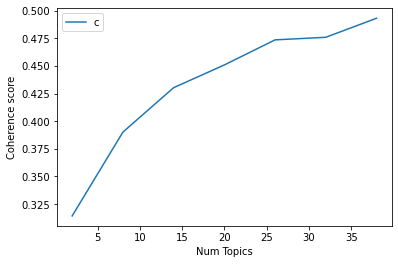

In [56]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3143
Num Topics = 8  has Coherence Value of 0.3901
Num Topics = 14  has Coherence Value of 0.4303
Num Topics = 20  has Coherence Value of 0.4508
Num Topics = 26  has Coherence Value of 0.4735
Num Topics = 32  has Coherence Value of 0.4759
Num Topics = 38  has Coherence Value of 0.4931


In [63]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(16,
  '0.096*"ley" + 0.068*"derecho" + 0.045*"usar" + 0.038*"legal" + '
  '0.030*"armar" + 0.028*"federal" + 0.026*"abortar" + 0.023*"republicano" + '
  '0.019*"casar" + 0.019*"constitucional"'),
 (23,
  '0.160*"trump" + 0.036*"provida" + 0.033*"beber" + 0.030*"presidente" + '
  '0.018*"campaign" + 0.018*"falto" + 0.018*"moral" + 0.018*"comunidad" + '
  '0.015*"negro" + 0.015*"afroamericano"'),
 (7,
  '0.048*"publicar" + 0.041*"millón" + 0.032*"primero" + 0.029*"grupo" + '
  '0.027*"album" + 0.025*"estadounidense" + 0.023*"basar" + 0.020*"formar" + '
  '0.018*"banda" + 0.018*"civil"'),
 (21,
  '0.097*"mujer" + 0.054*"juez" + 0.043*"vida" + 0.035*"peligrar" + '
  '0.031*"tratar" + 0.029*"justicia" + 0.029*"venir" + 0.019*"representar" + '
  '0.018*"querer" + 0.018*"abortar"'),
 (0,
  '0.064*"ahora" + 0.054*"bien" + 0.046*"saber" + 0.042*"destruir" + '
  '0.033*"presidente" + 0.027*"vez" + 0.025*"entonces" + 0.025*"cambiar" + '
  '0.023*"incluso" + 0.023*"izquierdista"'),
 (13,
  '0.05

## Finding the dominant topic in each sentence

In [64]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.0778,"valorar, coser, hablar, ninos, imponer, defender, matar, promover, cristiano, personar","Si esto te da asco, mucho asco, entonces es que estás comenzando a entender la mentalidad republicana... Los ""valores familiares"" de la activista contra el aborto fueron expuestos como mentiras para que toda la nación las viera. Comentarios Cruelmente Racistas Sobre su Propio Hijo Adoptivo: Linda Oradora de la Convención Republicana"
1,1,0.0,0.0385,"ahora, bien, saber, destruir, presidente, vez, entonces, cambiar, incluso, izquierdista",There you go! #hypocrites
2,2,23.0,0.0464,"trump, provida, beber, presidente, campaign, falto, moral, comunidad, negro, afroamericano","If true, this is a very serious charge."
3,3,25.0,0.1117,"justice, political, race, executive_order, post, law, candidate, signed, coronavirus, pastor","Interesting analysis regarding Roe v Wade as a political issue Is abortion the one issue that should determine how Christians vote? In this insane election year, Christians are debating a whole host of issues. The character of the president. Immigration. Race. The environment. The police. COVID-19. But in all these debates, one issue arises that seems to trump them all: Abortion. And there is one solution to abortion: Overturning Roe v. Wade, the Supreme Court decision that legalized abortion in 1973. Without Roe, abortion would still be illegal. Problem solved. Except the reality is much more complicated than that. Starting with the fact that Roe didn’t make abortion legal, and overturning Roe wouldn’t make abortion illegal. Throw in the fact that the abortion rate in 1972 - before Roe - was actually HIGHER than it is today, and things get really confusing. Our friend David French, a pro-life civil liberties attorney, recently wrote about the reality of politics and abortion in America today. When Holy Post co-host Skye Jethani echoed French’s point of view on Twitter, people asked if we could summarize it with a video. So we did. This is a tough topic. You may disagree with David and Skye. And that’s okay. We just think it’s a conversation worth having. (For a transcript of this video w/citations, go to"
4,4,2.0,0.0541,"decir, ano, mayor, sexual, nino, causar, escuchar, problema, ley, sentenciar",Presidential elections have consequences.
5,5,25.0,0.0825,"justice, political, race, executive_order, post, law, candidate, signed, coronavirus, pastor","Prominent evangelical leaders have just released a statement urging pro-life evangelicals to vote for Joe Biden. The signers include John Huffman, board chair emeritus of Christianity Today; Richard Foster, best-selling author of Celebration of Discipline; Jerushah Duford, Billy Graham’s granddaughter; Brenda Salter McNeil, author, speaker and long-time I VCF leader; John Perkins, founder of the Christian Community Development Association; the two authors of this piece; and a number of former presidents of evangelical universities. The statement points out that better politics could correct many problems that violate the sanctity of human life. Poverty, lack of health care, racism and climate change all kill persons created in the image of God. They are all pro-life issues. Their statement acknowledges that “as pro-life evangelicals, we disagree with Vice President Biden and the Democratic platform on the issue of abortion.” “But we believe,” the statement continues, “that a biblically shaped commitment to the sanctity of human life compels us to a consistent ethic of life that affirms the sanctity of human life from beginning to end. “"
6,6,0.0,0.0385,"ahora, bien, saber, destruir, presidente, vez, entonces, cambiar, incluso, izquierdista","It harms Christians credibility when they prioritize abortion over other social issues -- such as racism and poverty, writes Bishop Mark Seitz. Catholics Shouldnt Only Care About Abortion While Voting, Texas Bishop Says"
7,7,7.0,0.1061,"publicar, millón, primero,

## Find the most representative document for each topic

In [65]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3141,"ahora, bien, saber, destruir, presidente, vez, entonces, cambiar, incluso, izquierdista","La inadmisible ofensa de un llorón de tiranos!!! Donal Trump es el presidente de los Estados Unidos de América… y Melania Trump, la Primera Dama de esta gran nación… Hacer un comentario como el que hizo el activista""periodista"" izquierdista Ismael Calá.. que además de activista se destacó muy bien por su llantén sobre las cenizas del ex dictador Fidel Castro. Eso es inadmisible … Ismael Calá:..."
1,1.0,0.2991,"hacer, democratas, vivir, trabajar, querer, frente, grande, seguir, traficar, embargar","POR LA SALVACION DE LOS ESTADOS UNIDOS DE NORTEAMERICA DEL COMUNISMO, SOCIALISMO, LIBERALISMO Y VANDALISMO OCIOSO! DONALD TRUMP A LA PRESIDENCIA PARA SIEMPRE! Mientras los demócratas son los demonios que quieren implantar el liberalismo corrupto, coludiendose con la prensa corrupta, donde por ejemplo CNN no tiene verguenza de mentir y promover la corrupción, mientras que bajo el concepto de di..."
2,2.0,0.4052,"decir, ano, mayor, sexual, nino, causar, escuchar, problema, ley, sentenciar","EL REGRESO DE LA LEY Y EL ORDEN Keith Raniere, líder de Nxivm Sex Cult, es sentenciado a 120 años de prisión En la sala del tribunal, más de una docena de víctimas dieron un testimonio desgarrador sobre cómo las manipuló y abusó sexualmente. Por Nicole Hong y Sean Piccoli 27 de octubre de 2020 Keith Raniere, de 60 años, fue declarado culpable el año pasado de tráfico sexual, extorsión, fraude ..."
3,3.0,0.6571,"liderar, trump, unir, historia, progresista, tan, poblar, escribir, lado, alto","¿QUIEN ES DONALD TRUMP? Mucho de lo que es el Presidente Trump hoy día, ha sido construido por la sociedad Estadounidense que acostumbra endiosar a sus líderes y personajes mediáticos, para luego bajarlos del pedestal y cogerlos a palos. Norte America aplaude el éxito material y de eso Donald Trump ha estado lleno toda su vida. Un hombre que despierta amores y odios, un tipo excéntrico que ha..."
4,4.0,0.6693,"americano, politica, paz, paises, equipar, financiero, medio, ciudadano, poderoso, pasar","DONALD TRUMP GANARÁ LAS ELECCIONES DE NOVIEMBRE 2020 ABRUMADORAMENTE! 10 SECRETOS DE SU ÉXITO No hay duda de que el Congreso y la Casa de Representantes pasará a ser republicano, las razones son muy simples. En primer lugar el equipo de campaña Donald Trump ha sido inmensamente superior al de Biden y al equipo desorientado demócrata. Segundo, la imagen presentada es patriótica, espiritual y d..."
5,5.0,0.7352,"presidente, hombre, decir, nuevo, bueno, mal, democratas, ano, negociar, guerra","- Dijeron que destruiría la economía ... la economía mejoró, y el desempleo y la pobreza se redujo a récords bajos históricos durante su presidencia. - Dijeron que deportaría a todos los ilegales y separaría las familias hispanas ... terminó deportando cientos de miles menos que Clinton, Bush y Obama. - Dijeron que incitaría más terrorismo islámico con su retórica ""islamofóbica"" ... extirpó I..."
6,6.0,0.6007,"social, impulsar, crear, tomar, generar, control, luchar, agenda, paises, plan","*ÚLTIMA REUNIÓN DEL FORO DE SAO PAULO* *Veamos los veinte puntos tratados en la reunión:* *1.* Después de la pandemia, se propone desarrollar *“el plan estratégico de la desestabilización”.* Aprovechar la coyuntura política y económica de los Estados Unidos. Bajo la hambruna, organizar a la gente, contra el sistema imperante. *2.* Generar *movilizaciones masivas*, como las anteriores al covid ..."
7,7.0,0.5492,"publicar, millón, primero, grupo, album, estadounidense, basar, formar, banda, civil","Algunas portadas de discos / canciones con mensajes subliminales pedófilos y pro-aborto. Son imagénes gráficas y nauseabundas. Estáis advertidos. Nombre en orden de aparición: 1. Youthanasia (eutanasia de la juventud), el sexto disco de estudio de la banda estadounidense, Megadeth. Su fecha de lanzamiento fue el 1 de noviembre de 1994, y más tarde, en 200

In [66]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [67]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,11.0,"valorar, coser, hablar, ninos, imponer, defender, matar, promover, cristiano, personar",43.0,0.1165
1.0,0.0,"ahora, bien, saber, destruir, presidente, vez, entonces, cambiar, incluso, izquierdista",11.0,0.0298
2.0,23.0,"trump, provida, beber, presidente, campaign, falto, moral, comunidad, negro, afroamericano",8.0,0.0217
3.0,25.0,"justice, political, race, executive_order, post, law, candidate, signed, coronavirus, pastor",3.0,0.0081
4.0,2.0,"decir, ano, mayor, sexual, nino, causar, escuchar, problema, ley, sentenciar",4.0,0.0108
5.0,25.0,"justice, political, race, executive_order, post, law, candidate, signed, coronavirus, pastor",6.0,0.0163
6.0,0.0,"ahora, bien, saber, destruir, presidente, vez, entonces, cambiar, incluso, izquierdista",6.0,0.0163
7.0,7.0,"publicar, millón, primero, grupo, album, estadounidense, basar, formar, banda, civil",9.0,0.0244
8.0,25.0,"justice, political, race, executive_order, post, law, candidate, signed, coronavirus, pastor",9.0,0.0244
9.0,9.0,"vida, solo, religioso, ser, humano, personar, humanar, partir, dar, partido_democrata",9.0,0.0244
